## 题目 ##
1. 对连续型特征，可以用哪个函数可视化其分布？（给出你最常用的一个即可），并根据代码运行结果给出示例。 
2. 对两个连续型特征，可以用哪个函数得到这两个特征之间的相关性？根据代码运行结果，给出示例。 
3. 如果发现特征之间有较强的相关性，在选择线性回归模型时应该采取什么措施。 
4. 当采用带正则的模型以及采用随机梯度下降优化算法时，需要对输入（连续型）特征进行去量纲预处理。课程代码给出了用标准化（StandardScaler）的结果，请改成最小最大缩放（MinMaxScaler）去量纲 ，并重新训练最小二乘线性回归、岭回归、和Lasso模型。 
5. 代码中给出了岭回归（RidgeCV）和Lasso（LassoCV）超参数（alpha_）调优的过程，请结合两个最佳模型以及最小二乘线性回归模型的结果，给出什么场合应该用岭回归，什么场合用Lasso，什么场合用最小二乘。

 ## 回答 ##

 ### 对连续型特征，可以用哪个函数可视化其分布？并根据代码运行结果给出示例。  ###

可以用提琴图 seaborn.violinplot()可视化分布

代码示例：

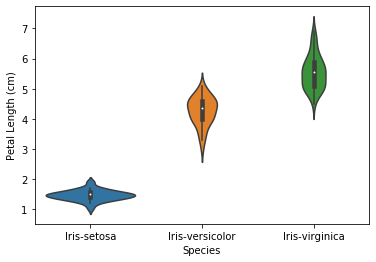

In [2]:
import pandas as pd
import seaborn as sb

iris_data = pd.read_csv('data/iris.csv') # 鸢尾花数据
sb.violinplot(x='Species', y='Petal Length (cm)', data=iris_data)

### 对两个连续型特征，可以用哪个函数得到这两个特征之间的相关性？根据代码运行结果，给出示例。 

可以用pandas.DataFrame.corr()方法计算出特征间的相关矩阵，然后根据相关矩阵用seaborn.heatmap()画出热力图可视化特征间的相关程度

代码示例：

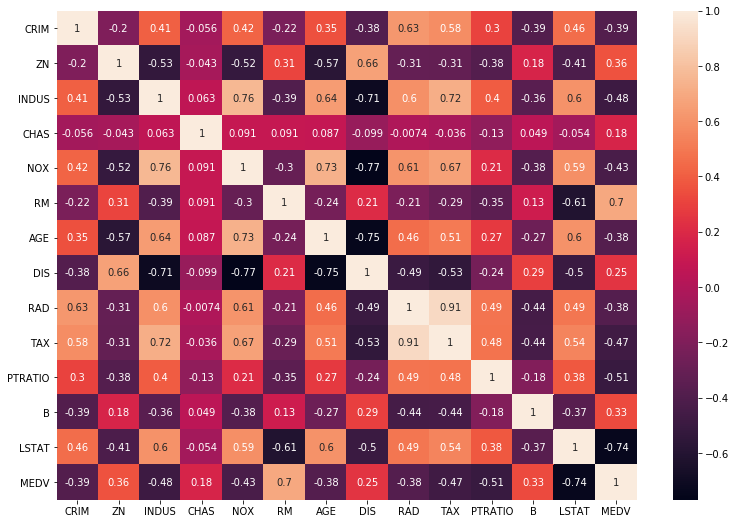

In [9]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13,9)) # 设置图片大小
house_data = pd.read_csv('data/boston_housing.csv') # 波士顿房价数据
corr_df = house_data.corr()
sb.heatmap(data=corr_df,annot=True) # annot为True时，在每个热力图单元格中写入数据值

上图反映出房价（MEDV）和房间数（RM）成最大正相关（0.7），房价（MEDV）和低收入人群比例（RM）成最大负相关

数据字段说明
1. CRIM：人均犯罪率 ；
2. ZN：住宅用地的比例（对超过两万五千平方英尺的区域） ；整数
3. INDUS：城镇中非零售营业比例；
4. CHAS：是否靠近Charles河的边界；整数
5. NOX：一氧化氮浓度 ；
6. RM：住宅平均房间数；
7. AGE：1940年之前建造的自住房屋的比例；
8. DIS：距离波士顿五个中心的加权距离；
9. RAD：高速公路的便利指数（索引）；整数
10. TAX ：每一万美元财产的全额财产税率； 整数
11. PTRATIO ：城乡师生比例；PTRATIO
12. B ：黑人比例
13. LSTAT ：低收入人群比例

### 如果发现特征之间有较强的相关性，在选择线性回归模型时应该采取什么措施。 

如果发现特征之间有较强的相关性，可以在特征层面上进行PCA降维处理，或在模型层面加正则项。

### 当采用带正则的模型以及采用随机梯度下降优化算法时，需要对输入（连续型）特征进行去量纲预处理。课程代码给出了用标准化（StandardScaler）的结果，请改成最小最大缩放（MinMaxScaler）去量纲 ，并重新训练最小二乘线性回归、岭回归、和Lasso模型。 

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# 1. 读取数据
data = pd.read_csv('data/boston_housing.csv',encoding='utf-8')
# data.head()

# 2. 数据预处理

# 2.1 数据去噪
data = data[data['MEDV']<50] 

# 2.2 数据分离
y = data['MEDV']
X = data.drop(columns='MEDV')
# 对分离出来的y做log变换
y_log = np.log1p(y)

# 2.3 离散型特征独热编码
X['RAD'].astype('object')
X_rad = X.RAD
X_rad = pd.get_dummies(X_rad, prefix='RAD')
X = X.drop(columns='RAD')
feat_names = X.columns

# 2.4 连续型特征去量纲
mms = MinMaxScaler()
X = mms.fit_transform(X)
y = mms.fit_transform(y.values.reshape(-1,1))
y_log = mms.fit_transform(y_log.values.reshape(-1,1))

# 将分离的数据连接起来
fe_data = pd.DataFrame(data=X, columns=feat_names, index=data.index) # 创建DataFrame
fe_data = pd.concat([fe_data,X_rad], axis=1, ignore_index=False) # 连接独热编码过的RAD
fe_data['MEDV'] = y # 加上y
fe_data['log_MEDV'] = y_log # 加上log_y
# 将完成预处理的数据写入文件
# fe_data.to_csv('data/FE_boston_housing.csv', index=False, encoding='utf-8')

# 3. 训练线性回归模型

# 3.1 准备数据

# 分离出X和y
y = fe_data['MEDV']
X = fe_data.drop(columns=['MEDV','log_MEDV'])
# 把X, y分割成训练集和校验集两部分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# 3.2 训练最小二乘线性回归

# 使用默认配置初始化最小二乘线性回归模型
lr = LinearRegression()

# 用训练数据训练模型参数
lr.fit(X_train, y_train)

# 用训练好的模型进行预测
y_test_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(X_train)

# 用r2_score评估模型性能

# 评估在测试集上的拟合程度
print('The r2 score of LinearRegression on test is', r2_score(y_test, y_test_pred_lr))

# 评估在训练集上的拟合程度
print('The r2 score of LInearRegression on train is', r2_score(y_train, y_train_pred_lr))

# 3.3 训练岭回归

# 初始化岭回归模型
rc = RidgeCV(alphas=[0.01,0.1,1.0,10.0,100.0], store_cv_values=True)

# 训练模型参数
rc.fit(X_train, y_train)

# 预测
y_test_pred_rc = rc.predict(X_test)
y_train_pred_rc = rc.predict(X_train)

# 评估

# 测试集
print('The r2 score of RidgeCV on test is', r2_score(y_test, y_test_pred_rc))

# 训练集
print('The r2 score of RidgeCV on train is', r2_score(y_train, y_train_pred_rc))

# 3.4 训练Lasso

# 初始化Lasso模型
# ls = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0])
ls = LassoCV()

# 训练模型参数
ls.fit(X_train, y_train)

# 预测
y_test_pred_ls = ls.predict(X_test)
y_train_pred_ls = ls.predict(X_train)

# 评估
print('The r2 score of Lasso on test is', r2_score(y_test, y_test_pred_ls))
print('The r2 score of Lasso on train is', r2_score(y_train, y_train_pred_ls))

The r2 score of LinearRegression on test is 0.7954131185266785
The r2 score of LInearRegression on train is 0.7845907336479507
The r2 score of RidgeCV on test is 0.7951175801079113
The r2 score of RidgeCV on train is 0.7845139281998054
The r2 score of Lasso on test is 0.7935130528961374
The r2 score of Lasso on train is 0.7838702190328231


In [4]:
features_names = X.columns
df_coef = pd.DataFrame(dict(column=features_names, lr_coef=lr.coef_, rc_coef=rc.coef_, ls_coef=ls.coef_))
df_coef

,column,lr_coef,rc_coef,ls_coef
0,CRIM,-0.226651,-0.213714,-0.185755
1,ZN,0.110449,0.107739,0.100208
2,INDUS,-0.013009,-0.014895,-0.014731
3,CHAS,-0.004240,-0.003590,-0.000000
4,NOX,-0.128297,-0.123707,-0.115111
5,RM,0.386867,0.381740,0.385220
6,AGE,-0.026078,-0.026074,-0.023131
7,DIS,-0.299537,-0.290094,-0.268897
8,TAX,-0.131691,-0.128393,-0.117256
9,PTRATIO,-0.174622,-0.172708,-0.167379


### 代码中给出了岭回归（RidgeCV）和Lasso（LassoCV）超参数（alpha_）调优的过程，请结合两个最佳模型以及最小二乘线性回归模型的结果，给出什么场合应该用岭回归，什么场合用Lasso，什么场合用最小二乘。

最小二乘： 目标函数只考虑了模型对训练样本的拟合程度，容易过拟合，适用于与特征之间相关性不强的数据

岭回归： 使得线性回归系数收缩，模型稳定。当输入特征之间存在共线性时使用较好。适用于与特征之间有一些相关性的数据

Lasso回归： 当正则参数取合适值时，使得有些线性回归系数为0，得到稀疏模型。 当输入特征多，有些特征与目标变量之间相关性很弱时，可能只选择强相关的特征，模型解释性好。 适用于与特征之前有很多强相关性的数据